# Tendencies along the filament

We define an axis that is along the direction of the filament and see if with respect to this, there are tendencies in velocity

This way, we see if there are for example different coherent structures in velocity, noticeable changes in sigma along the filament in the direction of SVS13, etc

Right now, we are only using the whole fit results (without QA and filtering) for HC3N and N2Hp. In particular this means **we will see outflows in the KDE**

In [1]:
import numpy as np
import os
from astropy.wcs import WCS
from astropy.io import fits
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
import astropy.units as u
import sys
sys.path.append('/home/mvaldivi/velocity_tools')
from velocity_tools import coordinate_offsets
import matplotlib.pyplot as plt

In [2]:
# we want to compare both molecules so we do files for both
mol1 = 'N2Hp'
mol2 = 'HC3N'
mol1label = r'N$_2$H$^+$'
mol2label = r'HC$_3$N'
ncomp1 = 2
ncomp2 = 3

mlex1file_mol1 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol1)
mlex2file_mol1 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x2_filtered_QA.fits'.format(mol1)
if ncomp1 == 3: mlex3file_mol1 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x3_filtered_QA.fits'.format(mol1)
ncompfilebayes_mol1 = '../bayes_frame/nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol1)

mlex1file_mol2 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol2)
mlex2file_mol2 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x2_filtered_QA.fits'.format(mol2)
if ncomp2 == 3: mlex3file_mol2 = '../bayes_frame/nested-sampling/{}/NGC1333-SE-mle-x3_filtered_QA.fits'.format(mol2)
ncompfilebayes_mol2 = '../bayes_frame/nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol2)

# for saving
kdevelfiledist_mol1 = '{}_kde_velocity_along_filament.npy'.format(mol1)
kdesigfiledist_mol1 = '{}_kde_sigma_along_filament.npy'.format(mol1)

kdevelfilecut_mol1 = '{}_kde_velocity_across_filament.npy'.format(mol1)
kdesigfilecut_mol1 = '{}_kde_sigma_across_filament.npy'.format(mol1)

kdevelfiledist_mol2 = '{}_kde_velocity_along_filament.npy'.format(mol2)
kdesigfiledist_mol2 = '{}_kde_sigma_along_filament.npy'.format(mol2)

kdevelfilecut_mol2 = '{}_kde_velocity_across_filament.npy'.format(mol2)
kdesigfilecut_mol2 = '{}_kde_sigma_across_filament.npy'.format(mol2)

# constants
distance = 298 * u.pc

In [3]:
# loading files

# molecule 1
mlex1_mol1 = fits.getdata(mlex1file_mol1)
mlex2_mol1 = fits.getdata(mlex2file_mol1)
if ncomp1 == 3: mlex3_mol1 = fits.getdata(mlex3file_mol1) 
ncomp_map_mol1 = fits.getdata(ncompfilebayes_mol1)
header_mol1 = fits.getheader(ncompfilebayes_mol1)
wcs1 = WCS(header_mol1)

xarray1 = np.linspace(0, header_mol1['NAXIS1']-1, header_mol1['NAXIS1'])
yarray1 = np.linspace(0, header_mol1['NAXIS2']-1, header_mol1['NAXIS2'])
XX1, YY1 = np.meshgrid(xarray1, yarray1)

pixsizearcsec1 = (header_mol1['CDELT2'] * u.deg).to(u.arcsec)

# molecule 2
mlex1_mol2 = fits.getdata(mlex1file_mol2)
mlex2_mol2 = fits.getdata(mlex2file_mol2)
if ncomp2 == 3: mlex3_mol2 = fits.getdata(mlex3file_mol2) 
ncomp_map_mol2 = fits.getdata(ncompfilebayes_mol2)
header_mol2 = fits.getheader(ncompfilebayes_mol2)
wcs2 = WCS(header_mol2)

xarray2 = np.linspace(0, header_mol2['NAXIS1']-1, header_mol2['NAXIS1'])
yarray2 = np.linspace(0, header_mol2['NAXIS2']-1, header_mol2['NAXIS2'])
XX2, YY2 = np.meshgrid(xarray2, yarray2)

pixsizearcsec2 = (header_mol2['CDELT2'] * u.deg).to(u.arcsec)

In [4]:
# quantities of interest
# molecule 1
vel1g_mol1 = mlex1_mol1[1] # velocity
vel2g1_mol1 = mlex2_mol1[1]
vel2g2_mol1 = mlex2_mol1[4]
if ncomp1 == 3: 
    vel3g1_mol1 = mlex3_mol1[1]
    vel3g2_mol1 = mlex3_mol1[4]
    vel3g3_mol1 = mlex3_mol1[7]
    velmaster_mol1 = np.array([vel1g_mol1, vel2g1_mol1, vel2g2_mol1, vel3g1_mol1, vel3g2_mol1, vel3g3_mol1])
else:
    velmaster_mol1 = np.array([vel1g_mol1, vel2g1_mol1, vel2g2_mol1])
    
sig1g_mol1 = mlex1_mol1[2] #velocity dispersion
sig2g1_mol1 = mlex2_mol1[2]
sig2g2_mol1 = mlex2_mol1[5]
if ncomp1 == 3: 
    sig3g1_mol1 = mlex3_mol1[2]
    sig3g2_mol1 = mlex3_mol1[5]
    sig3g3_mol1 = mlex3_mol1[8]
    sigmaster_mol1 = np.array([sig1g_mol1, sig2g1_mol1, sig2g2_mol1, sig3g1_mol1, sig3g2_mol1, sig3g3_mol1])
else:
    sigmaster_mol1 = np.array([sig1g_mol1, sig2g1_mol1, sig2g2_mol1])

# molecule 2
vel1g_mol2 = mlex1_mol2[1]
vel2g1_mol2 = mlex2_mol2[1]
vel2g2_mol2 = mlex2_mol2[4]
if ncomp2 == 3: 
    vel3g1_mol2 = mlex3_mol2[1]
    vel3g2_mol2 = mlex3_mol2[4]
    vel3g3_mol2 = mlex3_mol2[7]
    velmaster_mol2 = np.array([vel1g_mol2, vel2g1_mol2, vel2g2_mol2, vel3g1_mol2, vel3g2_mol2, vel3g3_mol2])
else:
    velmaster_mol2 = np.array([vel1g_mol2, vel2g1_mol2, vel2g2_mol2])
    
sig1g_mol2 = mlex1_mol2[2]
sig2g1_mol2 = mlex2_mol2[2]
sig2g2_mol2 = mlex2_mol2[5]
if ncomp2 == 3: 
    sig3g1_mol2 = mlex3_mol2[2]
    sig3g2_mol2 = mlex3_mol2[5]
    sig3g3_mol2 = mlex3_mol2[8]
    sigmaster_mol2 = np.array([sig1g_mol2, sig2g1_mol2, sig2g2_mol2, sig3g1_mol2, sig3g2_mol2, sig3g3_mol2])
else:
    sigmaster_mol2 = np.array([sig1g_mol2, sig2g1_mol2, sig2g2_mol2])


In [5]:
# building the map and the coordinate offsets with an angle
rotangle = (-54 * u.deg).to(u.rad).value # degrees clockwise
XXprime1 = XX1 * np.cos(rotangle) + YY1 * np.sin(rotangle)
YYprime1 = -XX1 * np.sin(rotangle) + YY1 * np.cos(rotangle)

XXprime2 = XX2 * np.cos(rotangle) + YY2 * np.sin(rotangle)
YYprime2 = -XX2 * np.sin(rotangle) + YY2 * np.cos(rotangle)


Text(0.5, 1.0, 'Rotated Y value')

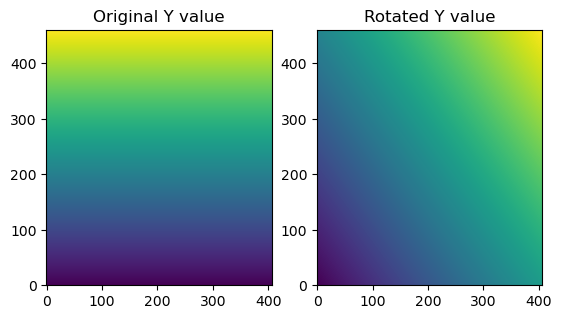

In [6]:
# This is just to check that the rotation was done in the expected angle
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(YY1, origin='lower')
ax.set_title('Original Y value')
ax2 = fig.add_subplot(122)
ax2.imshow(YYprime1, origin='lower')
ax2.set_title('Rotated Y value')
# ok all good

In [7]:
# y are the distance along the filament and x are across
# distarray are for along the filament, cutarray are for across
# molecule 1
mask_data_1g_mol1 = np.where(ncomp_map_mol1==1)
mask_data_2g_mol1 = np.where(ncomp_map_mol1==2)
if ncomp1 == 3: 
    mask_data_3g_mol1 = np.where(ncomp_map_mol1==3)
    velarray_mol1 = np.concatenate([vel1g_mol1[mask_data_1g_mol1], vel2g1_mol1[mask_data_2g_mol1], vel2g2_mol1[mask_data_2g_ml1], 
                                   vel3g1_mol1[mask_data_3g_mol1], vel3g2_mol1[mask_data_3g_mol1], vel3g2_mol1[mask_data_3g_mol1]])
    sigarray_mol1 = np.concatenate([sig1g_mol1[mask_data_1g_mol1], sig2g1_mol1[mask_data_2g_mol1], sig2g2_mol1[mask_data_2g_mol1], 
                                   sig3g1_mol1[mask_data_3g_mol1], sig3g2_mol1[mask_data_3g_mol1], sig3g2_mol1[mask_data_3g_mol1]])
    distarray_mol1 = np.concatenate([YYprime1[mask_data_1g_mol1], YYprime1[mask_data_2g_mol1], YYprime1[mask_data_2g_mol1],
                                     YYprime1[mask_data_3g_mol1], YYprime1[mask_data_3g_mol1], YYprime1[mask_data_3g_mol1]]) * pixsizearcsec1.value * distance.value 
    cutarray_mol1 = np.concatenate([XXprime1[mask_data_1g_mol1], XXprime1[mask_data_2g_mol1], XXprime1[mask_data_2g_mol1],
                                     XXprime1[mask_data_3g_mol1], XXprime1[mask_data_3g_mol1], XXprime1[mask_data_3g_mol1]]) * pixsizearcsec1.value * distance.value 

else:
    velarray_mol1 = np.concatenate([vel1g_mol1[mask_data_1g_mol1], vel2g1_mol1[mask_data_2g_mol1], vel2g2_mol1[mask_data_2g_mol1]]) 
    sigarray_mol1 = np.concatenate([sig1g_mol1[mask_data_1g_mol1], sig2g1_mol1[mask_data_2g_mol1], sig2g2_mol1[mask_data_2g_mol1]]) 
    distarray_mol1 = np.concatenate([YYprime1[mask_data_1g_mol1], YYprime1[mask_data_2g_mol1], YYprime1[mask_data_2g_mol1]]) * pixsizearcsec1.value * distance.value 
    cutarray_mol1 = np.concatenate([XXprime1[mask_data_1g_mol1], XXprime1[mask_data_2g_mol1], XXprime1[mask_data_2g_mol1]]) * pixsizearcsec1.value * distance.value 


# molecule 2
mask_data_1g_mol2 = np.where(ncomp_map_mol2==1)
mask_data_2g_mol2 = np.where(ncomp_map_mol2==2)
if ncomp2 == 3: 
    mask_data_3g_mol2 = np.where(ncomp_map_mol2==3)
    velarray_mol2 = np.concatenate([vel1g_mol2[mask_data_1g_mol2], vel2g1_mol2[mask_data_2g_mol2], vel2g2_mol2[mask_data_2g_mol2], 
                                   vel3g1_mol2[mask_data_3g_mol2], vel3g2_mol2[mask_data_3g_mol2], vel3g2_mol2[mask_data_3g_mol2]])
    sigarray_mol2 = np.concatenate([sig1g_mol2[mask_data_1g_mol2], sig2g1_mol2[mask_data_2g_mol2], sig2g2_mol2[mask_data_2g_mol2], 
                                   sig3g1_mol2[mask_data_3g_mol2], sig3g2_mol2[mask_data_3g_mol2], sig3g2_mol2[mask_data_3g_mol2]])
    distarray_mol2 = np.concatenate([YYprime2[mask_data_1g_mol2], YYprime2[mask_data_2g_mol2], YYprime2[mask_data_2g_mol2],
                                     YYprime2[mask_data_3g_mol2], YYprime2[mask_data_3g_mol2], YYprime2[mask_data_3g_mol2]]) * pixsizearcsec2.value * distance.value 
    cutarray_mol2 = np.concatenate([XXprime2[mask_data_1g_mol2], XXprime2[mask_data_2g_mol2], XXprime2[mask_data_2g_mol2],
                                     XXprime2[mask_data_3g_mol2], XXprime2[mask_data_3g_mol2], XXprime2[mask_data_3g_mol2]]) * pixsizearcsec2.value * distance.value 


else:
    velarray_mol2 = np.concatenate([vel1g_mol2[mask_data_1g_mol2], vel2g1_mol2[mask_data_2g_mol2], vel2g2_mol2[mask_data_2g_mol2]]) 
    sigarray_mol2 = np.concatenate([sig1g_mol2[mask_data_1g_mol2], sig2g1_mol2[mask_data_2g_mol2], sig2g2_mol2[mask_data_2g_mol2]]) 
    distarray_mol2 = np.concatenate([YYprime2[mask_data_1g_mol2], YYprime2[mask_data_2g_mol2], YYprime2[mask_data_2g_mol2]]) * pixsizearcsec2.value * distance.value 
    cutarray_mol2 = np.concatenate([XXprime2[mask_data_1g_mol2], XXprime2[mask_data_2g_mol2], XXprime2[mask_data_2g_mol2]]) * pixsizearcsec2.value * distance.value 


## Gradients along the filament

### Velocity

In [8]:
# here we build the space for the KDE to be plotted
xmin = 0
xmax = 160000
# y is velocity lsr
ymin = 6
ymax = 9

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdevelfilecut_mol1):
    gd_vlos_mol1 = np.isfinite(velarray_mol1*distarray_mol1)
    values_mol1 = np.vstack([distarray_mol1[gd_vlos_mol1], velarray_mol1[gd_vlos_mol1]])
    kernel_mol1 = gaussian_kde(values_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdevelfiledist_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdevelfiledist_mol1)
    
if not os.path.exists(kdevelfiledist_mol2):
    gd_vlos_mol2 = np.isfinite(velarray_mol2*distarray_mol2)
    values_mol2 = np.vstack([distarray_mol2[gd_vlos_mol2], velarray_mol2[gd_vlos_mol2]])
    kernel_mol2 = gaussian_kde(values_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdevelfiledist_mol2, zz_mol2)
else:
    zz_mol2 = np.load(kdevelfiledist_mol2)

/tmp/ipykernel_1743/3406105836.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_1743/3406105836.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


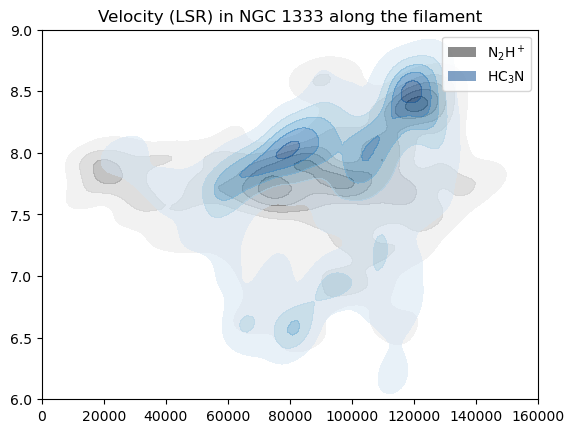

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels)
ax.set_title('Velocity (LSR) in NGC 1333 along the filament')

fig.savefig('KDE_vlsr_along_filament.pdf', bbox_inches='tight')

Note here that a larger density of points is due to the thickness of the filament. Also, remember HC3N has less points but this shows only relative density, so it can still happen that the apparent difference is not significant.

### Velocity dispersion

In [10]:
# here we build the space for the KDE to be plotted
xmin = 0
xmax = 160000
# y is velocity dispersion
ymin = 0
ymax = 1.
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdesigfiledist_mol1):
    gd_sig_mol1 = np.isfinite(sigarray_mol1*distarray_mol1)
    values_mol1 = np.vstack([distarray_mol1[gd_sig_mol1], sigarray_mol1[gd_sig_mol1]])
    kernel_mol1 = gaussian_kde(values_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdesigfiledist_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdesigfiledist_mol1)

if not os.path.exists(kdesigfiledist_mol2):
    gd_sig_mol2 = np.isfinite(sigarray_mol2*distarray_mol2)
    values_mol2 = np.vstack([distarray_mol2[gd_sig_mol2], sigarray_mol2[gd_sig_mol2]])
    kernel_mol2 = gaussian_kde(values_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdesigfiledist_mol2, zz_mol2)

else:
    zz_mol2 = np.load(kdesigfiledist_mol2)


/tmp/ipykernel_1743/691720626.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_1743/691720626.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


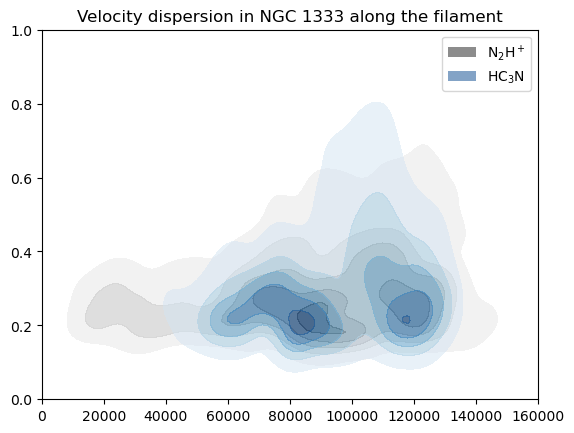

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels)
ax.set_title('Velocity dispersion in NGC 1333 along the filament')
fig.savefig('KDE_sig_along_filament.pdf', bbox_inches='tight')

In [12]:
# now we could do some clustering to determine which points are part of which layers


# also test the kde for sigma
# also put HC3N


## Gradients accross the filament

### Velocity

In [13]:
# here we build the space for the KDE to be plotted
xmin = -70000
xmax = 20000
# y is velocity lsr
ymin = 6
ymax = 9

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdevelfilecut_mol1):
    gcut_vlos_mol1 = np.isfinite(velarray_mol1*cutarray_mol1)
    values_across_mol1 = np.vstack([cutarray_mol1[gcut_vlos_mol1], velarray_mol1[gcut_vlos_mol1]])
    kernel_mol1 = gaussian_kde(values_across_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdevelfilecut_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdevelfilecut_mol1)

if not os.path.exists(kdevelfilecut_mol2):
    gcut_vlos_mol2 = np.isfinite(velarray_mol2*cutarray_mol2)
    values_across_mol2 = np.vstack([cutarray_mol2[gcut_vlos_mol2], velarray_mol2[gcut_vlos_mol2]])
    kernel_mol2 = gaussian_kde(values_across_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdevelfilecut_mol2, zz_mol2)
else:
    zz_mol2 = np.load(kdevelfilecut_mol2)

/tmp/ipykernel_1743/2078872550.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_1743/2078872550.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


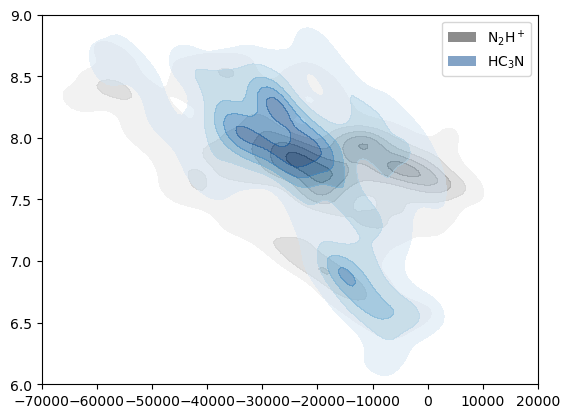

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels)

fig.savefig('KDE_vlsr_across_filament.pdf', bbox_inches='tight')

### Velocity dispersion

In [15]:
# here we build the space for the KDE to be plotted
xmin = -70000
xmax = 20000
# y is velocity dispersion
ymin = 0
ymax = 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

if not os.path.exists(kdesigfilecut_mol1):
    gcut_sig_mol1 = np.isfinite(sigarray_mol1*cutarray_mol1)
    values_mol1 = np.vstack([cutarray_mol1[gcut_sig_mol1], sigarray_mol1[gcut_sig_mol1]])
    kernel_mol1 = gaussian_kde(values_mol1)
    zz_mol1 = np.reshape(kernel_mol1(positions).T, xx.shape)
    zz_mol1 /= zz_mol1.max() 
    np.save(kdesigfilecut_mol1, zz_mol1)
else:
    zz_mol1 = np.load(kdesigfilecut_mol1)

if not os.path.exists(kdesigfilecut_mol2):
    gcut_sig_mol2 = np.isfinite(sigarray_mol2*cutarray_mol2)
    values_mol2 = np.vstack([cutarray_mol2[gcut_sig_mol2], sigarray_mol2[gcut_sig_mol2]])
    kernel_mol2 = gaussian_kde(values_mol2)
    zz_mol2 = np.reshape(kernel_mol2(positions).T, xx.shape)
    zz_mol2 /= zz_mol2.max() 
    np.save(kdesigfilecut_mol2, zz_mol2)

else:
    zz_mol2 = np.load(kdesigfilecut_mol2)


/tmp/ipykernel_1743/2822210645.py:3: UserWarning: The following kwargs were not used by contour: 'label'
  cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
/tmp/ipykernel_1743/2822210645.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)


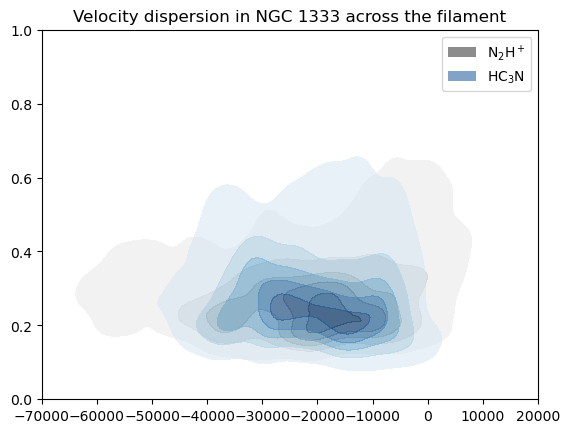

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
cs1 = ax.contourf(xx, yy, zz_mol1, cmap='Greys', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol1label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
cs2 = ax.contourf(xx, yy, zz_mol2, cmap='Blues', levels=np.arange(0.1, 1.2, 0.2), vmin=0., vmax=1.1, label=mol2label, alpha=0.5)
# ax.axhline(v_lsr.value, color='k')
ax.set_ylim([ymin,ymax])
ax.set_xlim([xmin,xmax])
areas = [plt.Rectangle((1, 1), 2, 2, fc=cs1.collections[-1].get_facecolor()[0]), 
         plt.Rectangle((1, 1), 2, 2, fc=cs2.collections[-1].get_facecolor()[0])]
labels = [mol1label, mol2label]
ax.legend(areas, labels)
ax.set_title('Velocity dispersion in NGC 1333 across the filament')
fig.savefig('KDE_sig_across_filament.pdf', bbox_inches='tight')